# 10 Animal Multiclassification Transfer Learning

It's a project of computer vision to classifying 10 different animals from custom sorted dataset. Original dataset from [Kaggle](https://www.kaggle.com/)

The dataset consists of `1000` images from each class in **train**, `100` images from each class in **valid** & **test** set (spider, horse, butterfly, elephant, chicken, cow, squirrel, sheep, cat, and dog).

So we will make two **functional API** models from **TensorFlow**, one from base model in [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications)(set to not trainable) and another one with [**Fine Tuning**](https://www.tensorflow.org/tutorials/images/transfer_learning) method with the same base model(unfrozening some of the parameters/layers, usually the last of layers). And we will implement **Data Augmentation** in our dataset from the begining.

So What we're going to cover:
1. Import dataset
2. View some dataset
3. Preprocessing images
  * Turn into tensors
  * resize the shape (128x128)
  * Implementing data augmentation
  * Seperate into 32 bathes
  * Normalize tensors (if need it)
4. Build callbacks model
  * Checkpoint
  * Early Stopping
5. Build and run a model with **functional API**
  * Model architecture
  * Compile a model
  * Fit data into the model
6. Evaluate model performance
  * History learned model
  * Making prediction with test dataset
  * Check metrics performance (`confusion matrix` and `classification report`)
  * Save a model for future use case
7. Re-create model architecture with **Fine Tuning** base model layers
8. Repeate the step **6** until satisfied
9. View prediction of a model to the test dataset randomly
10. Make a prediction with other pictures from public
11. Visualize dataset scores performance into dataframe and plot and find the most lowest scores from image class to evaluate in the future

In [1]:
# Check GPU avalability
!nvidia-smi

Fri Jul  5 23:46:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import Libraries required

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
import random
import pathlib
import os

### Import Datset

In [1]:
!unzip -q 10_animal_classifications.zip

In [4]:
# walkthrough the directory
for dirpath, dirnames, filenames in os.walk("10_animal_classifications"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '10_animal_classifications'.
There are 10 directories and 0 images in '10_animal_classifications/valid'.
There are 0 directories and 100 images in '10_animal_classifications/valid/dog'.
There are 0 directories and 100 images in '10_animal_classifications/valid/horse'.
There are 0 directories and 100 images in '10_animal_classifications/valid/spider'.
There are 0 directories and 100 images in '10_animal_classifications/valid/butterfly'.
There are 0 directories and 100 images in '10_animal_classifications/valid/elephant'.
There are 0 directories and 100 images in '10_animal_classifications/valid/cow'.
There are 0 directories and 100 images in '10_animal_classifications/valid/sheep'.
There are 0 directories and 100 images in '10_animal_classifications/valid/chicken'.
There are 0 directories and 100 images in '10_animal_classifications/valid/squirrel'.
There are 0 directories and 100 images in '10_animal_classifications/valid/cat'.
There are 10 direc

Let's view random image from dataset

### View random images from dataset

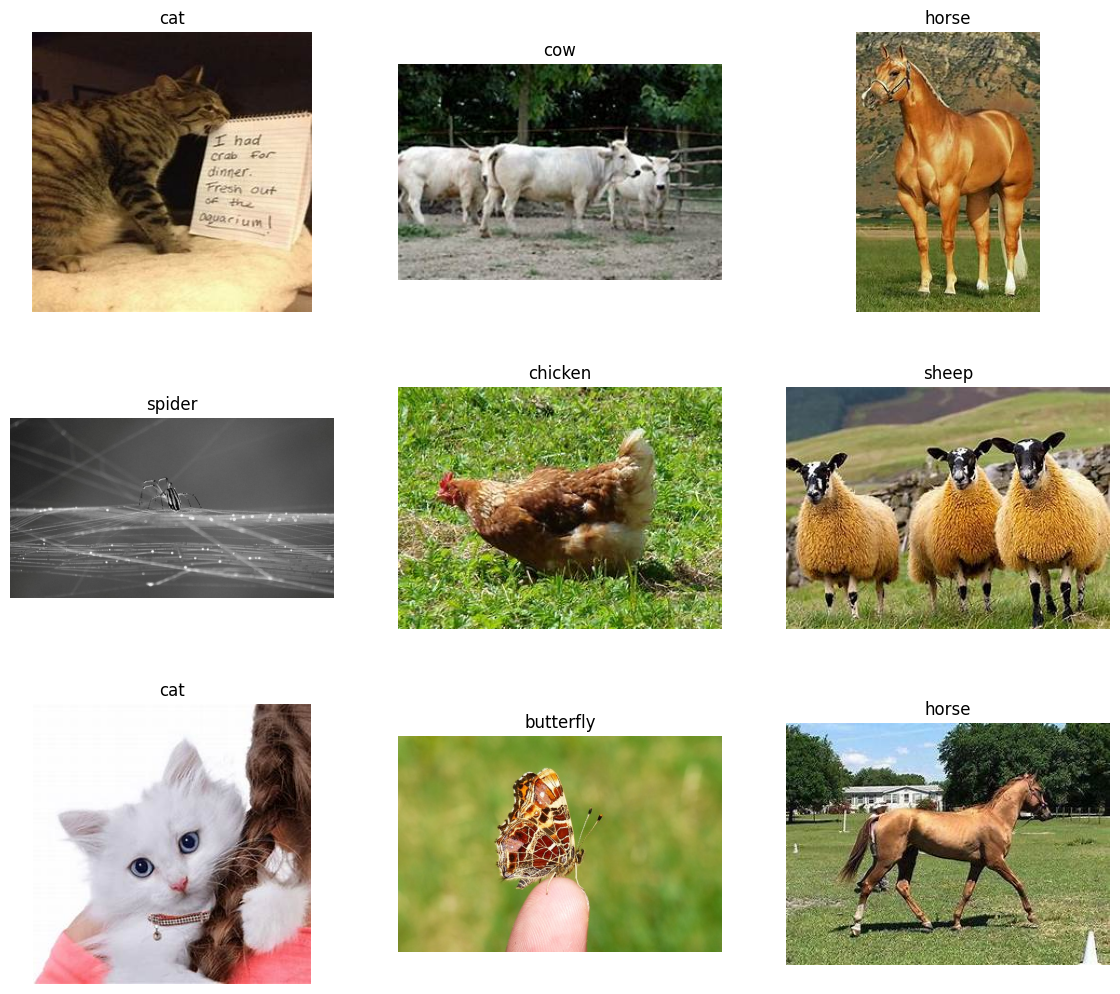

In [42]:
train_dir = "10_animal_classifications/train/"
valid_dir = "10_animal_classifications/valid/"
test_dir = "10_animal_classifications/test/"

plt.figure(figsize=(8,8))
plt.subplots_adjust(right=1.5, top=1.3)
for i in range(9):
  # get the image access
  rdm_class = random.choice(os.listdir(train_dir))
  class_dir = train_dir + rdm_class
  rdm_img = random.choice(os.listdir(class_dir))
  img_path = class_dir + '/' + rdm_img

  # Plot image
  plt.subplot(3, 3, i+1)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(rdm_class)
  plt.axis(False);

We've view some of the pictures from directories, let's preprocessing all of the images into tensor so we can work with the model later on

### Preprocessing images

* Turn into tensors
* Set image tensor shape (128x128)
* set batch size 32

In [43]:
IMG_SHAPES = (128, 128)
BATCH_SIZE = 32

train_data = keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SHAPES,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True)

valid_data = keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SHAPES,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True)

test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SHAPES,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False) # for better visualizing prediction

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [44]:
# Find the y_true
y_true = []

for image, label in test_data.unbatch():
  y_true.append(label.numpy().argmax())

y_true[:10], len(y_true)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1000)

In [45]:
# Create image class name
class_names = train_data.class_names
class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

* Create data augmentation

It will passed in the model architecture

In [47]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomZoom(0.3),
    keras.layers.RandomRotation(0.3),
    keras.layers.RandomHeight(0.2),
    keras.layers.RandomWidth(0.2),
    #keras.layers.Rescaling(1/255.0),   #we will use base model that doesn't have normalization layers init
], name="Data_Augmentation")

Now let's create model **callbacaks** with checkpoint and earlystopping

### Create Callbacks

* Checkpoint

Save the model in the best score (we set in the monitor param)

In [48]:
checkpoint_path = "model_checkpoint/multiclass_10_animals_model.ckpt"

checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_loss',
                                             save_best_only=True)

* Early Stopping

Prevent the model overfitting

In [49]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Now it's time to into the main course, build a model with **Transfer Learning** using **Functional API**

### Build a model

Non-trainable base model.

We will use [**EfficientNetB2**](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB2) that doesn't have normalization layers in its model architecture.

In [50]:
# set base model
base_model = tf.keras.applications.EfficientNetB2(include_top=False)
base_model.trainable = False

# Create an architecture model
inputs = keras.Input(IMG_SHAPES+(3,), name="Input_Layer")  #(128, 128, 3)
x = data_augmentation(inputs)  #passing into data augmentation process
x = base_model(x, training=False)  #passing into base model
x = keras.layers.GlobalAveragePooling2D(name="Feature_Vector")(x) #implementing feautre vector for dataset
outputs = keras.layers.Dense(len(class_names), activation='softmax' ,name="Output_Layer")(x)  #set output
model = keras.Model(inputs, outputs)

# Check model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 Feature_Vector (GlobalAver  (None, 1408)              0         
 agePooling2D)                                                   
                                                                 
 Output_Layer (Dense)        (None, 10)                14090     
                                                           

* Compile a model

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit a model

Orignal

In [52]:
NUM_EPOCHS = 10

history_one = model.fit(train_data,
                        epochs=NUM_EPOCHS,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=0.5 * int(len(valid_data)),  #time efficiency
                        callbacks=[early_stopping, checkpoint])

Epoch 1/10
313/313 [==============================] - 113s 330ms/step - loss: 1.0235 - accuracy: 0.6900 - val_loss: 0.3868 - val_accuracy: 0.9062
Epoch 2/10
313/313 [==============================] - 84s 268ms/step - loss: 0.6798 - accuracy: 0.7832 - val_loss: 0.3082 - val_accuracy: 0.9180
Epoch 3/10
313/313 [==============================] - 77s 245ms/step - loss: 0.6090 - accuracy: 0.8060 - val_loss: 0.2981 - val_accuracy: 0.9121
Epoch 4/10
313/313 [==============================] - 33s 105ms/step - loss: 0.5628 - accuracy: 0.8162 - val_loss: 0.3054 - val_accuracy: 0.9238
Epoch 5/10
313/313 [==============================] - 67s 214ms/step - loss: 0.5676 - accuracy: 0.8122 - val_loss: 0.2885 - val_accuracy: 0.9180
Epoch 6/10
313/313 [==============================] - 26s 83ms/step - loss: 0.5489 - accuracy: 0.8169 - val_loss: 0.3131 - val_accuracy: 0.9062
Epoch 7/10
313/313 [==============================] - 63s 202ms/step - loss: 0.5305 - accuracy: 0.8215 - val_loss: 0.2848 - val_ac

Now, it's time to evalaute model performance

### Evaluate model performance

In [53]:
first_results = model.evaluate(test_data)
first_results

32/32 [==============================] - 2s 74ms/step - loss: 0.2667 - accuracy: 0.9160


[0.2667368948459625, 0.9160000085830688]

In [54]:
# Find y_preds to compare with y_true
preds_probs = model.predict(test_data)
y_preds = preds_probs.argmax(axis=1)
y_preds[:10], y_preds.shape

32/32 [==============================] - 4s 35ms/step


(array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0]), (1000,))

 Check model history performance

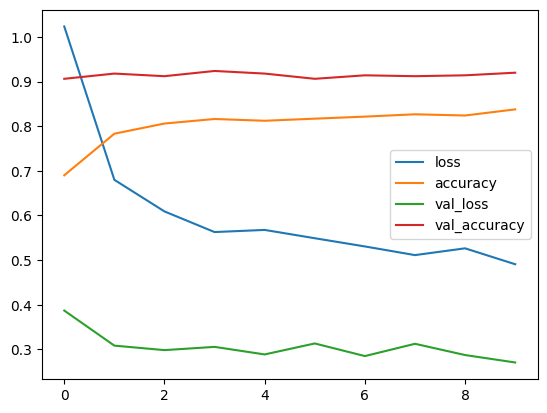

In [55]:
pd.DataFrame(history_one.history).plot();

* Check Confusion Matrix

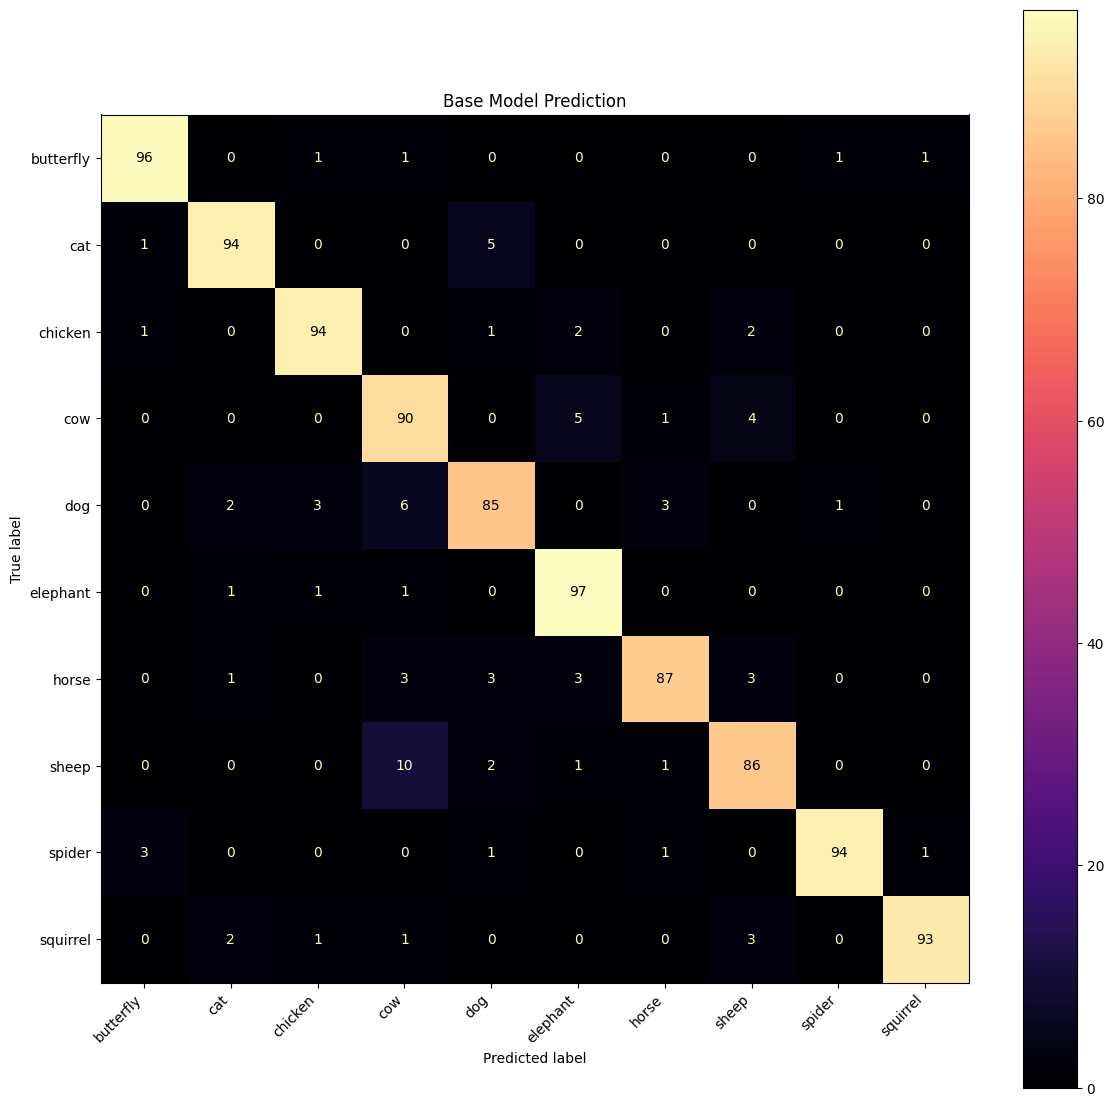

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(14, 14))
plt.title("Base Model Prediction")
cmp.plot(ax=ax, cmap='magma')
plt.xticks(rotation=45, ha='right');

Now let's create a new model with **Fine Tuning** method in the base model to improve the model performance...

### Fine Tuning base model

In [57]:
# Check model's layer

for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 Input_Layer True
1 Data_Augmentation True
2 efficientnetb2 False
3 Feature_Vector True
4 Output_Layer True


We can see the index **2** which our base model is not trainable(**False**). Let's tuning about 20 layers from our base model to set trainable.

In [58]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [59]:
# Check base model layers
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_1 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

And that's how to set the last **20** layers(custom) to set to be true. Let's check our model layers once again...

In [60]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 Input_Layer True
1 Data_Augmentation True
2 efficientnetb2 True
3 Feature_Vector True
4 Output_Layer True


Perfect!!!

Let's re-compile our model with a little bit a of change in `learning_rate` optimizer to set **x10 times** lower and then re-fit with the same parameters.

In [61]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(0.0001), metrics=["accuracy"])

# Check model summary after Fine Tuning
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 Feature_Vector (GlobalAver  (None, 1408)              0         
 agePooling2D)                                                   
                                                                 
 Output_Layer (Dense)        (None, 10)                14090     
                                                           

Massive improvement from original model **14090** trainable params, now we got **2841442** trainable params after fine tuning. Let's see if it's really worthy after we set trainable of 20 layers in base model...

### Re-fit a model after Fine Tuning

In [62]:
INITIAL_EPOCHS = NUM_EPOCHS * 2

history_two = model.fit(train_data,
                        epochs=INITIAL_EPOCHS,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=0.5 * int(len(valid_data)),
                        initial_epoch=history_one.epoch[-1],
                        callbacks=[early_stopping, checkpoint])

Epoch 10/20
313/313 [==============================] - 80s 211ms/step - loss: 0.4871 - accuracy: 0.8340 - val_loss: 0.2459 - val_accuracy: 0.9219
Epoch 11/20
313/313 [==============================] - 20s 64ms/step - loss: 0.4426 - accuracy: 0.8465 - val_loss: 0.2758 - val_accuracy: 0.9199
Epoch 12/20
313/313 [==============================] - 21s 67ms/step - loss: 0.4015 - accuracy: 0.8635 - val_loss: 0.2739 - val_accuracy: 0.9023
Epoch 13/20
313/313 [==============================] - 20s 62ms/step - loss: 0.3548 - accuracy: 0.8782 - val_loss: 0.2646 - val_accuracy: 0.9199


Well, it stops at **13** eoichs due early stopping...

Now, let's check model evalaution after doing fine tuning

### Evaluate model performance after Fine Tuning

In [63]:
second_results = model.evaluate(test_data)
second_results

32/32 [==============================] - 1s 35ms/step - loss: 0.2338 - accuracy: 0.9190


[0.23382353782653809, 0.9190000295639038]

In [64]:

# Compare with the first result
first_results

[0.2667368948459625, 0.9160000085830688]

We can see the improvement from the first model (non-trainable) to `Fine-Tuning` is: **0.3%**. It's indicated the base model itself are great from **EfficientNetB2** for this particular 10 multiclass animals.

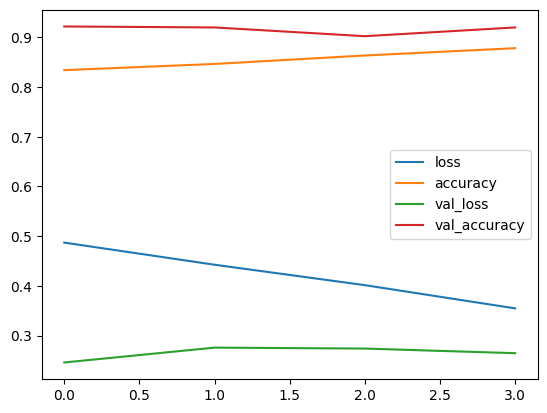

In [65]:
# Check model history learning after fine tuning
pd.DataFrame(history_two.history).plot();

In [66]:
preds_probs = model.predict(test_data)
y_preds = preds_probs.argmax(axis=1)
y_preds[:10], y_preds.shape

32/32 [==============================] - 3s 33ms/step


(array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0]), (1000,))

Check confusion matrix after fine tuning

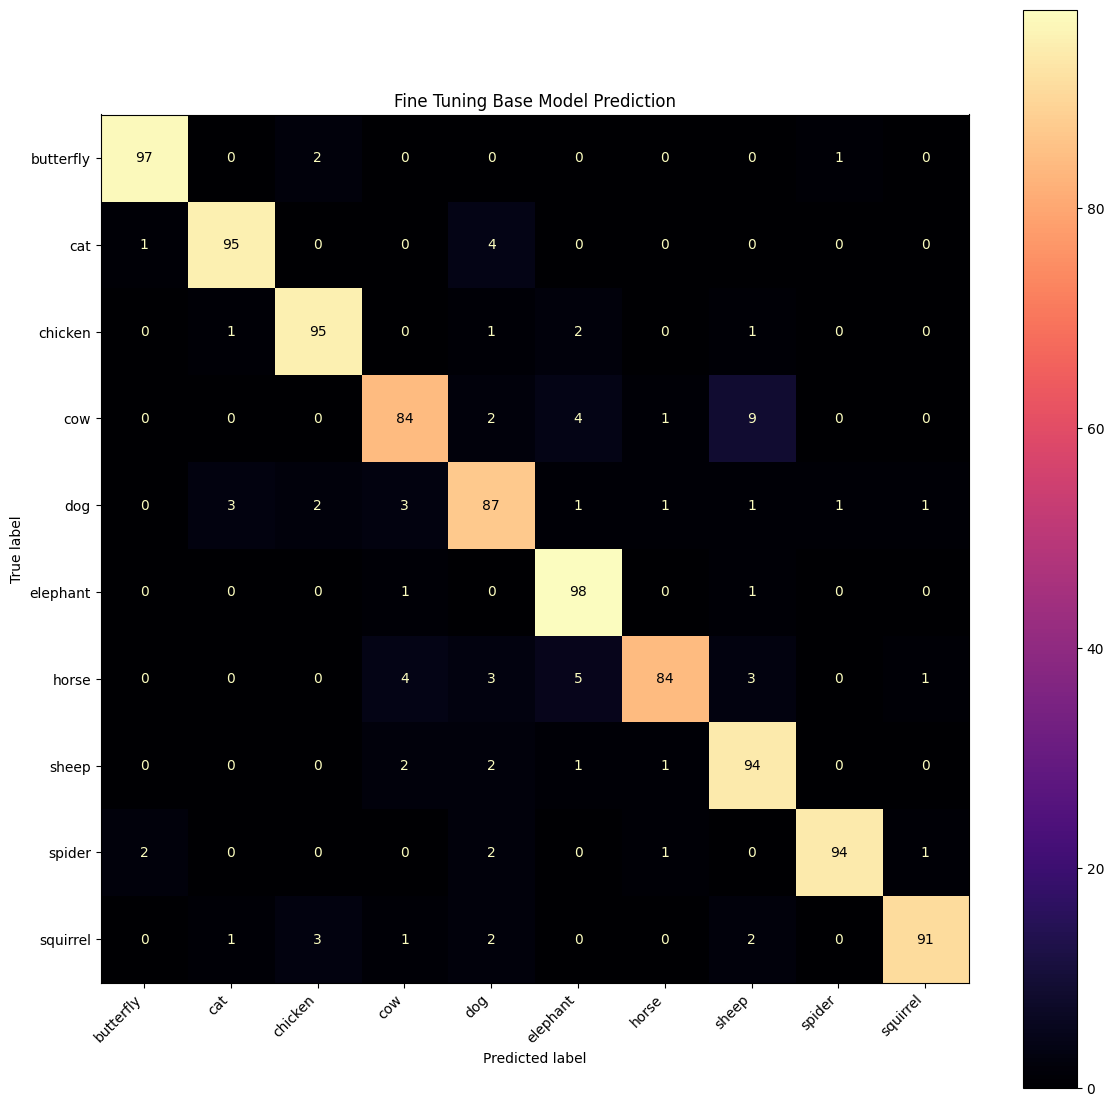

In [67]:
cm = confusion_matrix(y_true, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(14, 14))
plt.title("Fine Tuning Base Model Prediction")
cmp.plot(ax=ax, cmap='magma')
plt.xticks(rotation=45, ha='right');


Now let's compare between two different histories performance in a function to see the different after implemented **fine tuning**

In [68]:
def compare_histories(original_history, new_history, initial_epochs=10):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

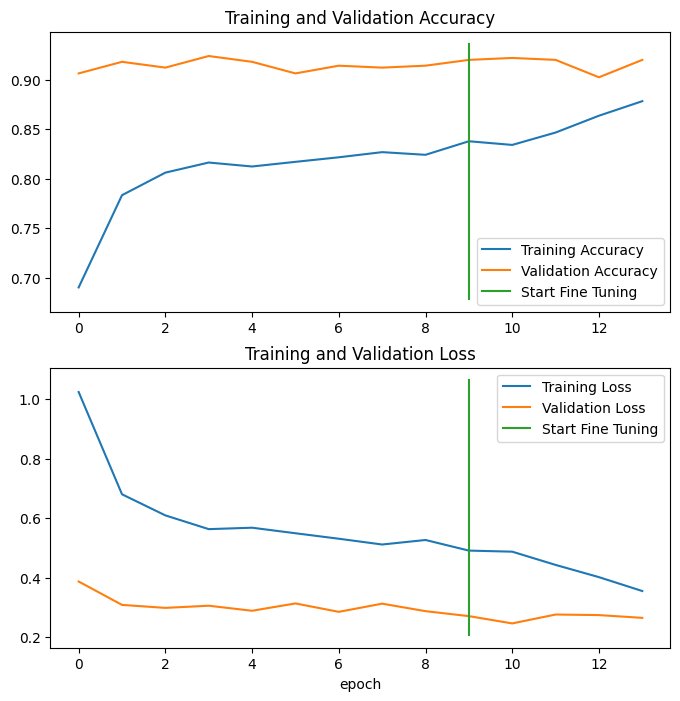

In [69]:
compare_histories(history_one, history_two, initial_epochs=10)

We can see the model history learn gets slightly improved from the first train, which is indeed compatible to boost model performance.

In order to be able use the model to predict images for the future, let's save it for usagebility

### Save and Load a model

In [70]:
# Save a model
model.save("EfficientNetB2_multiclass_10_animals_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
# Load a model
loaded_model = keras.models.load_model("EfficientNetB2_multiclass_10_animals_model.h5")
loaded_model.evaluate(test_data)

32/32 [==============================] - 7s 36ms/step - loss: 0.2338 - accuracy: 0.9190


[0.23382353782653809, 0.9190000295639038]

In [72]:
# Check if it's the same model we save before
second_results

[0.23382353782653809, 0.9190000295639038]

Now it's time to visualize the model prediction with the test dataset images!!!

### Visualize model prediction from test dataset images

But before that, we're going to build preprocessing image function for efficiency

In [75]:
# image preprocessing function
def image_prepross(filepath, scale=128, normalize=True):
  """
  Return image tensor of shape (128, 128, 3) with normalized values.
  ==============================================================
  filepath: image file path location (str).
  scale: tensor shape customisation, default=128 (128, 128, 3).
  normalize: 'True' set for scale the tensor (0-1), if 'False' will
  return values (0-255)
  """

  # read file image
  img = tf.io.read_file(filepath)
  # decode into tensor
  img_tensor = tf.io.decode_image(img)
  # reshape image
  img_tensor = tf.image.resize(img_tensor, [scale, scale])

  # normalize condition
  if normalize:
    return img_tensor/255.0
  else:
    return img_tensor

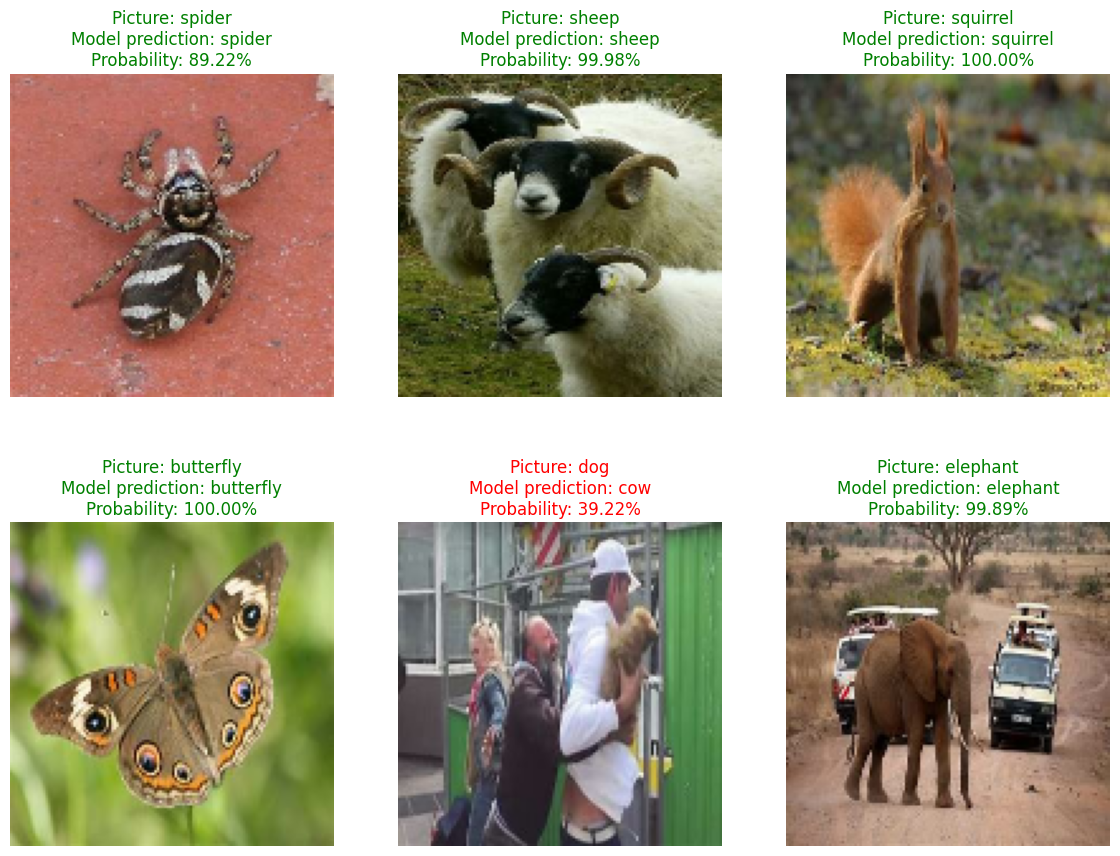

In [93]:
# visualize model prediction in test dataset
plt.figure(figsize=(8,8))
plt.subplots_adjust(right=1.5, top=1.7)
for i in range(6):
  # get the image access
  rdm_class = random.choice(os.listdir(test_dir))
  class_dir = test_dir + rdm_class
  rdm_img = random.choice(os.listdir(class_dir))
  img_path = class_dir + '/' + rdm_img

  # model predict
  img_tensor = image_prepross(img_path, scale=128, normalize=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img_tensor, axis=0), verbose=0) #set to be 4D(1, 128, 128, 3) add batch
  pred_class = class_names[int(pred_prob.argmax())]

  # plot model prediction
  plt.subplot(3, 3, i+1)
  plt.imshow(img_tensor/255.0)
  # model predict and true class condition
  if rdm_class == pred_class:
    color = 'green'
  else:
    color = 'red'
  plt.title(f"Picture: {rdm_class}\nModel prediction: {pred_class}\nProbability: {pred_prob.max() * 100:.2f}%", c=color)
  plt.axis(False);

We got mostly correct prediction as we expect from model evaluation accuracy. So now we will import images from the internet that hasn't seen by our model to make a prediction with it...

Also we want to build a function to cover all process (preprocessing image, pass in into the model, and plot the image)

### Make image prediction from the custom image

In [78]:
# create a function
def image_prediction(model, class_names, filepath, img_name=None, scale=128, normalize=True):
  """
  Return image plot prediction from a model params (multiclass 10 animals prediction).
  -----------------------------------------------------------------------------------
  model: Pre-trained model about 10 multiclass animals prediction.
  class_names: Name of all 10 animals set in (list).
  filepath: Custom image file path location (jpg, png, jpeg).
  img_name: Name of a animal in the picture.
  scale: Custom reshape image tensor (128, 128, 3) default=128.
  normalize: Return image tensor in scale (0-1) set 'True'. if 'False',
  will return original scale (0-255)
  """

  # preprocessing image
  img_tensor = image_prepross(filepath=filepath, scale=scale, normalize=normalize)

  # model predict
  pred_prob = model.predict(tf.expand_dims(img_tensor, axis=0), verbose=0) #set to be 4D(1, 128, 128, 3) add batch
  pred_class = class_names[int(pred_prob.argmax())]

  # plot model prediction
  if normalize:
    plt.imshow(img_tensor)
  else:
    plt.imshow(img_tensor/255.0)

  if img_name:
    if img_name.lower() == pred_class:
      color = 'green'
    else:
      color = 'red'
    plt.title(f"Picture: {img_name.lower()}\nModel prediction: {pred_class}\nProbability: {pred_prob.max() * 100:.2f}%", c=color)
    plt.axis(False);

  else:
    plt.title(f"Model prediction: {pred_class}\nProbability: {pred_prob.max() * 100:.2f}%")
    plt.axis(False);

In [79]:
# test in the cat image
!wget https://2.bp.blogspot.com/-Sspumd1xPgc/VvIrdvFY7WI/AAAAAAAAXvo/5wIOUxa95WoirmFNHqi0R5rDxHgB4ZkGw/s1600/001.JPG

--2024-07-06 00:25:38--  https://2.bp.blogspot.com/-Sspumd1xPgc/VvIrdvFY7WI/AAAAAAAAXvo/5wIOUxa95WoirmFNHqi0R5rDxHgB4ZkGw/s1600/001.JPG
Resolving 2.bp.blogspot.com (2.bp.blogspot.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to 2.bp.blogspot.com (2.bp.blogspot.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184370 (180K) [image/jpeg]
Saving to: ‘001.JPG’

001.JPG             100%[===================>] 180.05K  --.-KB/s    in 0.002s  

2024-07-06 00:25:38 (108 MB/s) - ‘001.JPG’ saved [184370/184370]



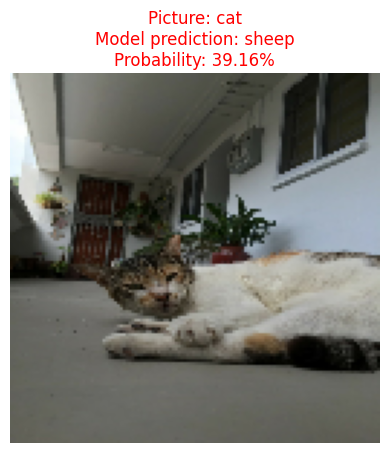

In [81]:
image_prediction(model=loaded_model,
                 class_names=class_names,
                 filepath='001.JPG',
                 img_name='CAT',
                 scale=128,
                 normalize=False)

We've got one prediction wrong in the first try. at least the probability of a model it's less 50%

Let's find 2 different pictures from different animals

In [84]:
!wget https://cs2.worldofmods.com/screenshots/f80ce/2015-05/original/7f44cae6596313cc1d496d22b96314a739ed9348/150798-javaw-2015-05-21-19-12-06-86.jpg

--2024-07-06 00:27:44--  https://cs2.worldofmods.com/screenshots/f80ce/2015-05/original/7f44cae6596313cc1d496d22b96314a739ed9348/150798-javaw-2015-05-21-19-12-06-86.jpg
Resolving cs2.worldofmods.com (cs2.worldofmods.com)... 176.9.9.213
Connecting to cs2.worldofmods.com (cs2.worldofmods.com)|176.9.9.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206027 (201K) [image/jpeg]
Saving to: ‘150798-javaw-2015-05-21-19-12-06-86.jpg’

150798-javaw-2015-0 100%[===================>] 201.20K   595KB/s    in 0.3s    

2024-07-06 00:27:46 (595 KB/s) - ‘150798-javaw-2015-05-21-19-12-06-86.jpg’ saved [206027/206027]



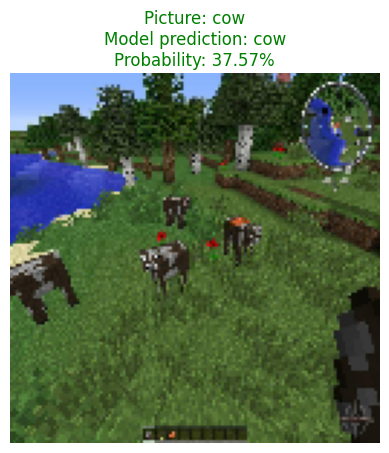

In [85]:
image_prediction(model=loaded_model,
                 class_names=class_names,
                 filepath='150798-javaw-2015-05-21-19-12-06-86.jpg',
                 img_name='Cow',
                 scale=128,
                 normalize=False)

This is cool!!! we grab a picture from video games with cow innit and it does predict corectly! Sometimes you didn't know what will comes from someone who wanna input it.

Alright, one more please....

In [86]:
!wget https://cdn.pixabay.com/photo/2014/05/13/07/25/spider-343189_1280.jpg

--2024-07-06 00:28:07--  https://cdn.pixabay.com/photo/2014/05/13/07/25/spider-343189_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251854 (246K) [binary/octet-stream]
Saving to: ‘spider-343189_1280.jpg’

spider-343189_1280. 100%[===================>] 245.95K  --.-KB/s    in 0.03s   

2024-07-06 00:28:07 (8.48 MB/s) - ‘spider-343189_1280.jpg’ saved [251854/251854]



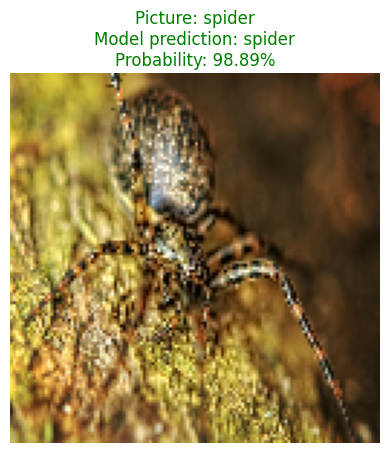

In [87]:
image_prediction(model=loaded_model,
                 class_names=class_names,
                 filepath='spider-343189_1280.jpg',
                 img_name='spider',
                 scale=128,
                 normalize=False)

**SOLID**

Now let's check all posible metrics in classification problem with [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

### Classification Report metrics

In [88]:
preds_probs = loaded_model.predict(test_data)
y_preds = preds_probs.argmax(axis=1)
y_preds[:10], y_preds.shape

32/32 [==============================] - 5s 36ms/step


(array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0]), (1000,))

In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.95      0.95      0.95       100
           2       0.93      0.95      0.94       100
           3       0.88      0.84      0.86       100
           4       0.84      0.87      0.86       100
           5       0.88      0.98      0.93       100
           6       0.95      0.84      0.89       100
           7       0.85      0.94      0.89       100
           8       0.98      0.94      0.96       100
           9       0.97      0.91      0.94       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



We can see all the classification problem metrics:
* precision
* recall
* f1-score
* accuracy

But would be better if we visualize the classification report in **DataFrame** and then plot them into horizontal bar. Let's take [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#f1-score) as a metrics we want to plot!

In [90]:
# set output as dictionary
multiclass_report = classification_report(y_true, y_preds, output_dict=True)

f1_score_dict = {}
# get only f1_score value
for k, v in multiclass_report.items():
  if k == 'accuracy': #stop before accuacry value
    break
  else:
    f1_score_dict[class_names[int(k)]] = v['f1-score']

f1_score_df = pd.DataFrame({"class_name": f1_score_dict.keys(),
                            "F1-score": f1_score_dict.values()}).sort_values("F1-score", ascending=False)

f1_score_df

class_name  F1-score
0  butterfly  0.970000
8     spider  0.959184
1        cat  0.950000
2    chicken  0.940594
9   squirrel  0.938144
5   elephant  0.928910
6      horse  0.893617
7      sheep  0.890995
3        cow  0.861538
4        dog  0.857143

Great!!! Let's make a plot to make it beautiful

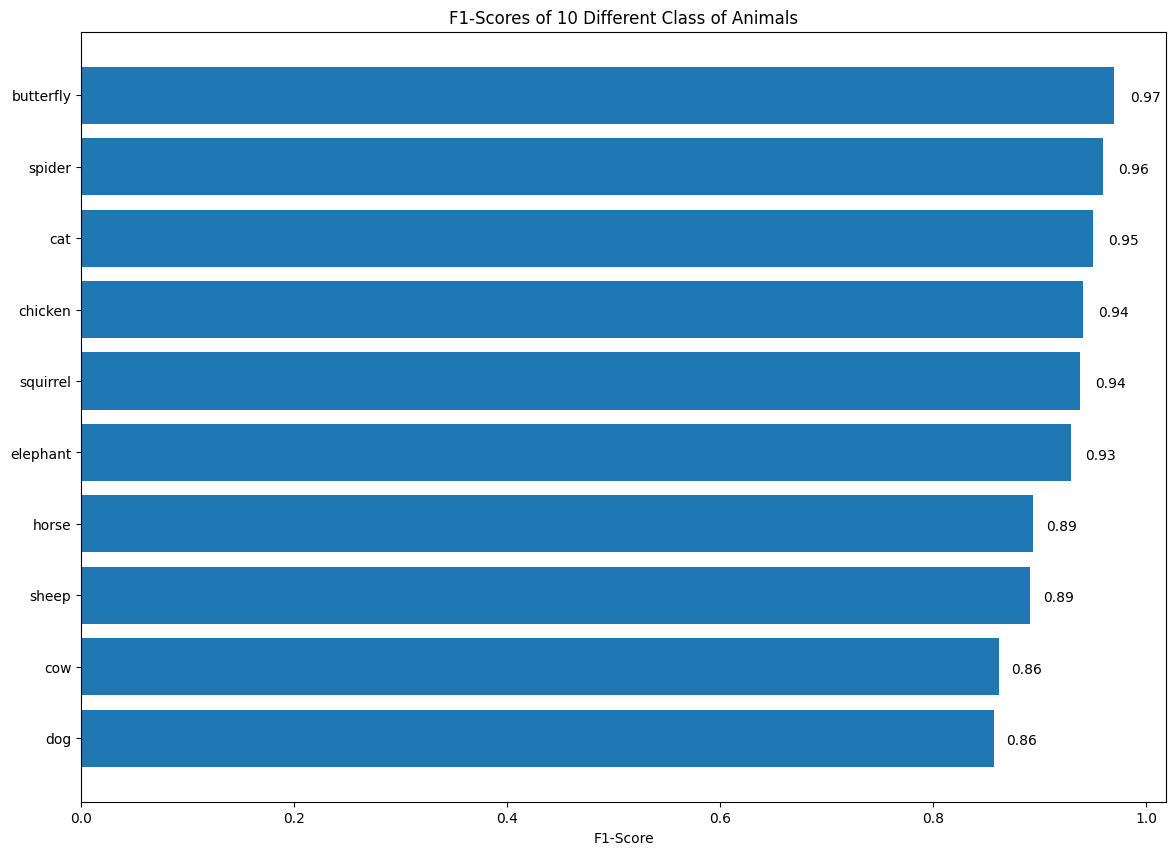

In [91]:
fig, ax = plt.subplots(figsize=(14, 10))
scores = ax.barh(range(len(f1_score_df)), f1_score_df['F1-score'].values)
ax.set_yticks(range(len(f1_score_df)))
ax.set_yticklabels(list(f1_score_df["class_name"]))
ax.set_xlabel("F1-Score")
ax.set_title("F1-Scores of 10 Different Class of Animals")
ax.invert_yaxis(); # reverse the order


def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

This is AWESOME! The lowest **F1-score** we got is from a class `dog` (0.86) which considering as high score. With combination of our base model **EfficientNetB2** with `data_augmentation` method and **fine tuning** some params/layers in the base model, we got final conclusion of how powerful the base model from **`tf.keras.applications`** model.

For more advance project, feel free to update the num of class or images dataset to be as many as posible and more data innit for complexity learn!!!